In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
import warnings
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

lifetime_bounds = [2,100]
region = 'tropics'
# Min number of MCS to plot
min_ntracks = 20

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]
bounds = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
    }

# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TOOCAN = {key:f'{dir_TOOCAN}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True


In [4]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_FV3.nc: True


In [5]:
for key, value in filenames_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_FV3.nc: True


## Show a map for the subset region

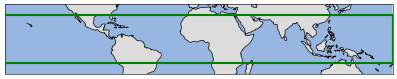

In [6]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [7]:
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
nsource = ds_pyflex.dims['source']
ds_pyflex

<xarray.Dataset>
Dimensions:                  (tracks: 4672, times: 500, nmaxpf: 3, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4668 4669 4670 4671
  * times                    (times) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4672), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4672), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4672), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4672, 500, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4672, 500, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Oct 23 15:28:20 2023

In [8]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
ds_moaap

<xarray.Dataset>
Dimensions:                  (tracks: 5093, times: 600, nmaxpf: 3, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5089 5090 5091 5092
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5093), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5093), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5093), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5093, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5093, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Sat Oct 28 13:39:41 2023

In [9]:
# Read all files and combine them with a new dimension 'source'
ds_toocan = xr.open_mfdataset(list(filenames_TOOCAN.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_toocan['source'] = list(name_map.keys())
ds_toocan

<xarray.Dataset>
Dimensions:                  (tracks: 37618, times: 600, nmaxpf: 3, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 271002 271138 271436
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 37618), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 37618), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 37618), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 37618, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 37618, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 37618, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 37618, 600), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                TOOCAN
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri Nov  3 15:47:04 2023

In [10]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2016-08-10', '2016-09-11'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-15, 30],
 [2, 100])

In [11]:
ds_pyflex.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Mon Oct 23 15:28:20 2023'}

In [12]:
# Get global attributes
pixel_radius = ds_pyflex.attrs['pixel_radius_km']
time_resolution = ds_pyflex.attrs['time_resolution_hour']

In [13]:
def find_tracks_start(ds_in):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )
    return ds_out

def get_land_ocean_ds(ds_in):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [14]:
dss_pyflex = find_tracks_start(ds_pyflex)

In [15]:
dss_moaap = find_tracks_start(ds_moaap)

In [16]:
dss_toocan = find_tracks_start(ds_toocan)

In [17]:
print(f'Number of MCS (PyFLEXTRKR)')
for key in dss_pyflex['source'].data:
    ntracks = np.count_nonzero(dss_pyflex.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (PyFLEXTRKR)
OBS: 2521
ARPEGE: 776
IFS: 2418
MPAS: 1200
NICAM: 2776
SAM: 2644
UM: 1603
FV3: 2054


In [18]:
print(f'Number of MCS (MOAAP)')
for key in dss_moaap['source'].data:
    ntracks = np.count_nonzero(dss_moaap.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (MOAAP)
OBS: 2199
ARPEGE: 205
IFS: 2569
MPAS: 1576
NICAM: 2071
SAM: 1031
UM: 1478
FV3: 1693


In [19]:
print(f'Number of MCS (TOOCAN)')
for key in dss_toocan['source'].data:
    ntracks = np.count_nonzero(dss_toocan.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TOOCAN)
OBS: 3830
ARPEGE: 608
IFS: 4758
MPAS: 1276
NICAM: 3745
SAM: 2451
UM: 2190
FV3: 3063


## Separate land vs. ocean MCS

In [20]:
dss_pyflex_l, dss_pyflex_o = get_land_ocean_ds(dss_pyflex)

In [21]:
dss_moaap_l, dss_moaap_o = get_land_ocean_ds(dss_moaap)

In [22]:
dss_toocan_l, dss_toocan_o = get_land_ocean_ds(dss_toocan)

In [23]:
# Get number of tracks for land vs. ocean
ntracks_pyflex_l = {}
ntracks_pyflex_o = {}
for key in dss_pyflex['source'].data:
    ntracks_pyflex_l[key] = np.count_nonzero(dss_pyflex_l.track_duration.sel(source=key) > 0)
    ntracks_pyflex_o[key] = np.count_nonzero(dss_pyflex_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_pyflex_l[ii]}')
print(f'Number of MCS - Land (PyFLEXTRKR): {ntracks_pyflex_l}')
print(f'Number of MCS - Ocean (PyFLEXTRKR): {ntracks_pyflex_o}')

Number of MCS - Land (PyFLEXTRKR): {'obs': 854, 'm1': 281, 'm2': 913, 'm3': 626, 'm4': 665, 'm5': 701, 'm6': 522, 'm7': 694}
Number of MCS - Ocean (PyFLEXTRKR): {'obs': 1224, 'm1': 342, 'm2': 1209, 'm3': 326, 'm4': 1642, 'm5': 1445, 'm6': 817, 'm7': 1035}


In [24]:
# Get number of tracks for land vs. ocean
ntracks_moaap_l = {}
ntracks_moaap_o = {}
for key in dss_moaap['source'].data:
    ntracks_moaap_l[key] = np.count_nonzero(dss_moaap_l.track_duration.sel(source=key) > 0)
    ntracks_moaap_o[key] = np.count_nonzero(dss_moaap_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_moaap_l[ii]}')
print(f'Number of MCS - Land (MOAAP): {ntracks_moaap_l}')
print(f'Number of MCS - Ocean (MOAAP): {ntracks_moaap_o}')

Number of MCS - Land (MOAAP): {'obs': 385, 'm1': 20, 'm2': 825, 'm3': 601, 'm4': 486, 'm5': 260, 'm6': 268, 'm7': 304}
Number of MCS - Ocean (MOAAP): {'obs': 1470, 'm1': 142, 'm2': 1481, 'm3': 645, 'm4': 1250, 'm5': 552, 'm6': 966, 'm7': 1077}


In [25]:
# Get number of tracks for land vs. ocean
ntracks_toocan_l = {}
ntracks_toocan_o = {}
for key in dss_toocan['source'].data:
    ntracks_toocan_l[key] = np.count_nonzero(dss_toocan_l.track_duration.sel(source=key) > 0)
    ntracks_toocan_o[key] = np.count_nonzero(dss_toocan_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_toocan_l[ii]}')
print(f'Number of MCS - Land (TOOCAN): {ntracks_toocan_l}')
print(f'Number of MCS - Ocean (TOOCAN): {ntracks_toocan_o}')

Number of MCS - Land (TOOCAN): {'obs': 1085, 'm1': 105, 'm2': 1548, 'm3': 491, 'm4': 893, 'm5': 808, 'm6': 458, 'm7': 752}
Number of MCS - Ocean (TOOCAN): {'obs': 2343, 'm1': 458, 'm2': 2847, 'm3': 567, 'm4': 2380, 'm5': 1339, 'm6': 1491, 'm7': 1973}


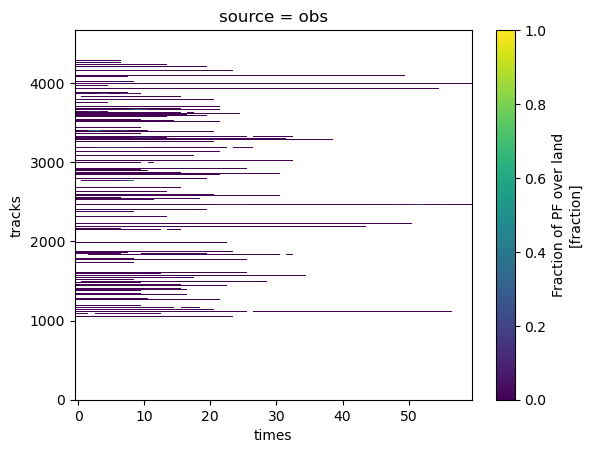

In [26]:
dss_pyflex_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

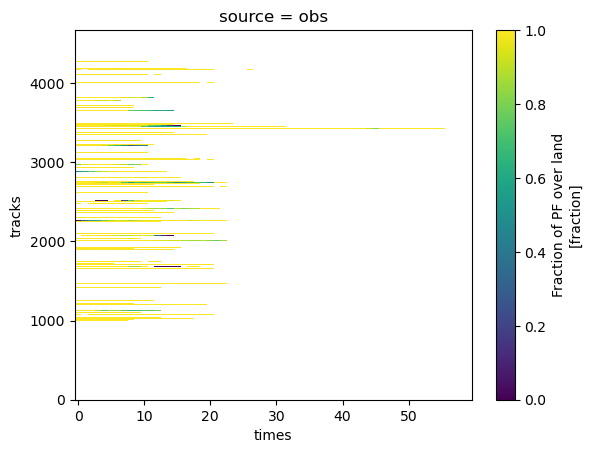

In [27]:
dss_pyflex_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

In [28]:
# TODO: use a simple method to separate possible merge/split tracks
# E.g., if max CCS area occur within the first 10% of a tracks start time: split; or within last 10% of a tracks end time: merge
# ds.ccs_area.max(dim='times')

## Functions for diurnal cycle analysis

In [29]:
def utc2lt(UTC, lon):
    """
    A simple function to convert UTC time to local solar time for a given longitude.
    
    Arguments:
       UTC: array-like
           Time in UTC.
       lon: array-like
           Longitude in degrees.
           
    Returns:
       localtime: array-like
           Local solar time.
    """
    
    # Hour per degree longitude 
    hourperdeg = 24./360.
    # Convert to local time
    localtime = UTC + lon * hourperdeg
    
    # Adjust time
    if np.count_nonzero(localtime >= 24) > 0:
        localtime[localtime >= 24] -= 24
    
    if np.count_nonzero(localtime < 0) > 0:
        localtime[localtime < 0] += 24

    return localtime

def harmonic_phase_amplitude(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    
    Arguments:
       var   = array to be analyzed, XT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
       
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
#     w = float(nt) / (2.*np.arccos(-1.))
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[0:nharm]
    phs = np.angle(ft)[1:nharm+1]
#     phs = np.angle(ft)[1:nharm+1] * binsize

    totvar = 0.5*np.sum(ampall*ampall)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
#         phs_offset_max = float(nt)/float(np1)  # max possible phase offset for this harmonic
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[n] = phs_offset_max - phs[n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[n] = np.where(phs[n]>phs_offset_max, phs[n]-phs_offset_max, phs[n])
        phs[n] = np.where(phs[n]<0, phs[n] + float(nt)*binsize/float(np1), phs[n])

        # Get percent variance explained by each harmonic.
        pvar[n] = np.where(zeros, 0., 100.*(0.5*amp[n]*amp[n])/totvar_nozeros)
    
    return amp, phs, pvar

In [30]:
def get_mcs_diurnal_hours(ds, binhour, mcs_status, ntracks):
    """
    Get MCS diurnal hour PDF in local time.
    """
    nsource = ds.dims['source']
    nbins = len(binhour)-1
    
    # Get base time (UTC)
    base_time = ds.base_time.load()
    # Convert base time to fractional hour
    hourUTC = base_time.dt.hour + (base_time.dt.minute / 60)
    # Convert longitudes from -180~+180 to 0~360
    if (ds.meanlon.min().data < 0):
        meanlon = ds.meanlon.load().data % 360
    else:
        meanlon = ds.meanlon.load().data
    # Convert UTC time to local time
    hourLT = utc2lt(hourUTC.data, meanlon)
    # Convert to DataArray for convenience
    hourLT = xr.DataArray(hourLT, coords={'source':ds.source, 'tracks':ds.tracks, 'times':ds.times}, dims=('source','tracks','times'))
    
    binrange = (np.min(binhour), np.max(binhour))

    # pdf_inithour = np.full((nsource, nbins), np.NaN, dtype=float)
    # pdf_mcshour = np.full((nsource, nbins), np.NaN, dtype=float)
    fillvals = np.full(nbins, np.NaN, dtype=float)
    pdf_inithour = {src: fillvals for src in name_map.keys()}
    pdf_mcshour = {src: fillvals for src in name_map.keys()}
    # Loop over each source in the DataSet
    for i, src in enumerate(ds['source'].data):
        if ntracks[src] > min_ntracks:
            # MCS initiation hours histogram
            pdf_inithour[src], bins = np.histogram(hourLT.isel(times=0).sel(source=src), bins=binhour, range=binrange, density=True)
            # MCS stage hours histogram
            pdf_mcshour[src], bins = np.histogram(hourLT.where(mcs_status == 1).sel(source=src), bins=binhour, range=binrange, density=True)
    
    return pdf_inithour, pdf_mcshour

In [31]:
# # # nsource = nsource
# nbins = len(binhour)-1
# fillvals = np.full(nbins, np.NaN, dtype=float)
# pdf_inithour = {src: fillvals for src in name_map.keys()}
# pdf_inithour

In [32]:
# Thresholds to define MCS mature stage
heavy_rainrate_thresh = dss_pyflex.attrs['heavy_rainrate_thresh']
mcs_min_rainvol_thresh = 20000.   # [km^2 mm/h] Min rain volume threshold
mcs_min_ccsarea_thresh = 40000.   # [km^2] Min CCS area threshold
pf_majoraxis_thresh = 100.   # [km] MCS PF major axis length threshold

# Get variables needed to define MCS mature stage
pf_volrain_pyflex = dss_pyflex.total_rain * pixel_radius**2
pf_maxrainrate_pyflex = dss_pyflex.pf_maxrainrate.isel(nmaxpf=0)
ccsarea_pyflex = dss_pyflex.ccs_area
pf_majoraxis_pyflex = dss_pyflex.pf_majoraxis

# In PyFLEXTRKR SAAG robust MCS code (robustmcspf_saag.py)
# Both the max rain rate & rain volume must exceed these thresholds & persist for >= 4 hours to be labeled MCS period
# This is a simplified version (ignore time continuity requirement)
# pf_mcsstatus_pyflex = (pf_maxrainrate_pyflex > heavy_rainrate_thresh) & (pf_volrain_pyflex > mcs_min_rainvol_thresh)

# Simple PF major axis length criteria
pf_mcsstatus_pyflex = pf_majoraxis_pyflex > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_pyflex = ccsarea_pyflex > mcs_min_ccsarea_thresh

In [33]:
# Get variables needed to define MCS mature stage
# pf_volrain_moaap = dss_moaap.total_rain * pixel_radius**2
# pf_maxrainrate_moaap = dss_moaap.pf_maxrainrate.isel(nmaxpf=0)
ccsarea_moaap = dss_moaap.ccs_area
pf_majoraxis_moaap = dss_moaap.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_moaap = pf_majoraxis_moaap > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_moaap = ccsarea_moaap > mcs_min_ccsarea_thresh

In [34]:
# Get variables needed to define MCS mature stage
# pf_volrain_toocan = dss_toocan.total_rain * pixel_radius**2
# pf_maxrainrate_toocan = dss_toocan.pf_maxrainrate.isel(nmaxpf=0)
ccsarea_toocan = dss_toocan.ccs_area
pf_majoraxis_toocan = dss_toocan.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_toocan = pf_majoraxis_toocan > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_toocan = ccsarea_toocan > mcs_min_ccsarea_thresh

## Calculate diurnal cycle (histogram of MCS time in LT)

In [35]:
# Set up diurnal hour bins
binhour = np.arange(0, 24.1, 2)
binhour_v = binhour[:-1] + np.diff(binhour)/2

In [36]:
# pdf_inithour_pyflex_l, pdf_mcshour_pyflex_l = get_mcs_diurnal_hours(dss_pyflex_l, binhour, ccs_mcsstatus_pyflex, ntracks_pyflex_l)
pdf_inithour_pyflex_l, pdf_mcshour_pyflex_l = get_mcs_diurnal_hours(dss_pyflex_l, binhour, pf_mcsstatus_pyflex, ntracks_pyflex_l)

# pdf_inithour_pyflex_o, pdf_mcshour_pyflex_o = get_mcs_diurnal_hours(dss_pyflex_o, binhour, ccs_mcsstatus_pyflex, ntracks_pyflex_o)
pdf_inithour_pyflex_o, pdf_mcshour_pyflex_o = get_mcs_diurnal_hours(dss_pyflex_o, binhour, pf_mcsstatus_pyflex, ntracks_pyflex_o)

In [37]:
# pdf_inithour_moaap_l, pdf_mcshour_moaap_l = get_mcs_diurnal_hours(dss_moaap_l, binhour, ccs_mcsstatus_moaap, ntracks_moaap_l)
pdf_inithour_moaap_l, pdf_mcshour_moaap_l = get_mcs_diurnal_hours(dss_moaap_l, binhour, pf_mcsstatus_moaap, ntracks_moaap_l)

# pdf_inithour_moaap_o, pdf_mcshour_moaap_o = get_mcs_diurnal_hours(dss_moaap_o, binhour, ccs_mcsstatus_moaap, ntracks_moaap_o)
pdf_inithour_moaap_o, pdf_mcshour_moaap_o = get_mcs_diurnal_hours(dss_moaap_o, binhour, pf_mcsstatus_moaap, ntracks_moaap_o)

In [38]:
# pdf_inithour_toocan_l, pdf_mcshour_toocan_l = get_mcs_diurnal_hours(dss_toocan_l, binhour, ccs_mcsstatus_toocan, ntracks_toocan_l)
pdf_inithour_toocan_l, pdf_mcshour_toocan_l = get_mcs_diurnal_hours(dss_toocan_l, binhour, pf_mcsstatus_toocan, ntracks_toocan_l)

# pdf_inithour_toocan_o, pdf_mcshour_toocan_o = get_mcs_diurnal_hours(dss_toocan_o, binhour, ccs_mcsstatus_toocan, ntracks_toocan_o)
pdf_inithour_toocan_o, pdf_mcshour_toocan_o = get_mcs_diurnal_hours(dss_toocan_o, binhour, pf_mcsstatus_toocan, ntracks_toocan_o)

In [39]:
# pdf_inithour_pyflex_l
pdf_inithour_moaap_l
# for key in name_map:
#     print(pdf_inithour_moaap_l[key])

{'obs': array([0.02857143, 0.03116883, 0.02597403, 0.01948052, 0.03766234,
        0.07272727, 0.12077922, 0.05064935, 0.03506494, 0.03376623,
        0.01818182, 0.02597403]),
 'm1': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'm2': array([0.02121212, 0.02848485, 0.02424242, 0.02787879, 0.03333333,
        0.03393939, 0.09333333, 0.10727273, 0.04909091, 0.02969697,
        0.01939394, 0.03212121]),
 'm3': array([0.01331115, 0.01913478, 0.03161398, 0.05906822, 0.11980033,
        0.12229617, 0.04492512, 0.01996672, 0.01580699, 0.01497504,
        0.01996672, 0.01913478]),
 'm4': array([0.02366255, 0.0308642 , 0.01748971, 0.02160494, 0.02366255,
        0.0462963 , 0.12037037, 0.10082305, 0.04012346, 0.03497942,
        0.01851852, 0.02160494]),
 'm5': array([0.03269231, 0.01538462, 0.03076923, 0.04807692, 0.06153846,
        0.05384615, 0.05192308, 0.07307692, 0.05      , 0.04038462,
        0.01538462, 0.02692308]),
 'm6': array([0.00932836, 0.01119403, 0.029

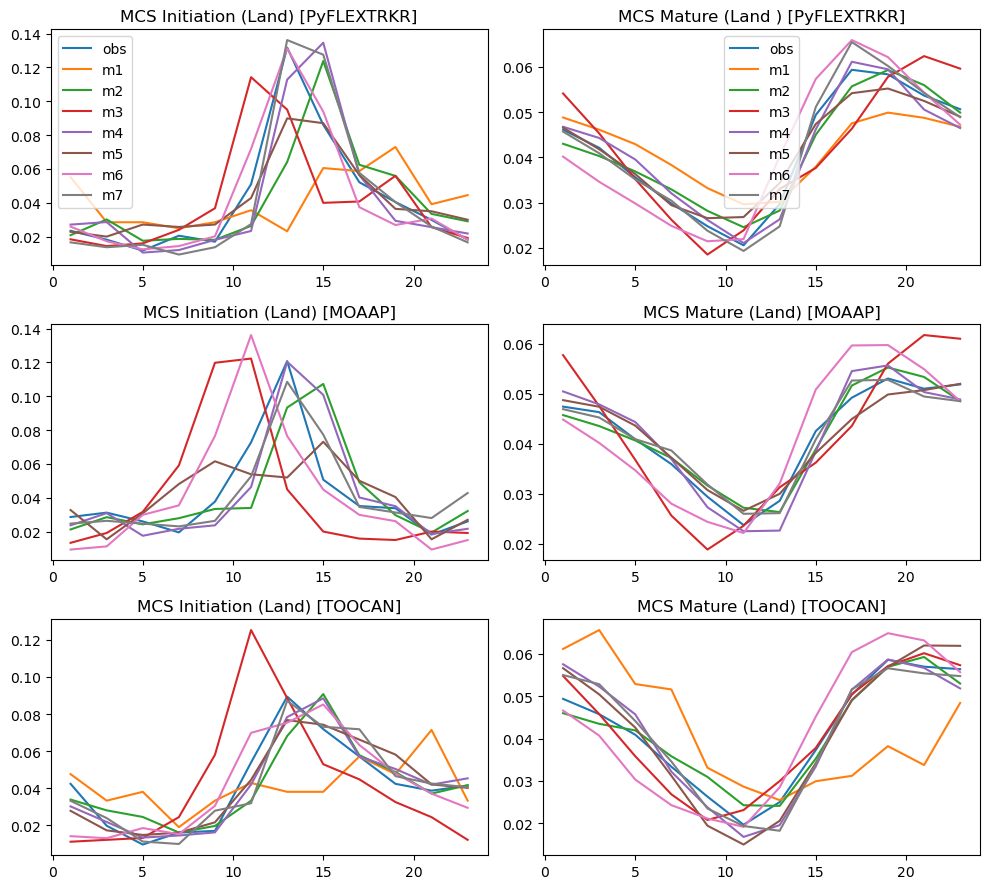

In [40]:
fig, axes = plt.subplots(3, 2, figsize=(10,9), dpi=100)
# PyFLEXTRKR
ax00 = axes[0][0]
for key in name_map:
    ax00.plot(binhour_v, pdf_inithour_pyflex_l[key], label=f'{key}')
    ax00.legend()
ax01 = axes[0][1]
for key in name_map:
    ax01.plot(binhour_v, pdf_mcshour_pyflex_l[key], label=f'{key}')
    ax01.legend()
ax00.set_title('MCS Initiation (Land) [PyFLEXTRKR]')
ax01.set_title('MCS Mature (Land ) [PyFLEXTRKR]')
    
# MOAAP
ax10 = axes[1][0]
for key in name_map:
    ax10.plot(binhour_v, pdf_inithour_moaap_l[key], label=f'{key}')
ax11 = axes[1][1]
for key in name_map:
    ax11.plot(binhour_v, pdf_mcshour_moaap_l[key], label=f'{key}')
ax10.set_title('MCS Initiation (Land) [MOAAP]')
ax11.set_title('MCS Mature (Land) [MOAAP]')
    
# TOOCAN
ax20 = axes[2][0]
for key in name_map:
    ax20.plot(binhour_v, pdf_inithour_toocan_l[key], label=f'{key}')
ax21 = axes[2][1]
for key in name_map:
    ax21.plot(binhour_v, pdf_mcshour_toocan_l[key], label=f'{key}')
ax20.set_title('MCS Initiation (Land) [TOOCAN]')
ax21.set_title('MCS Mature (Land) [TOOCAN]')

fig.tight_layout()

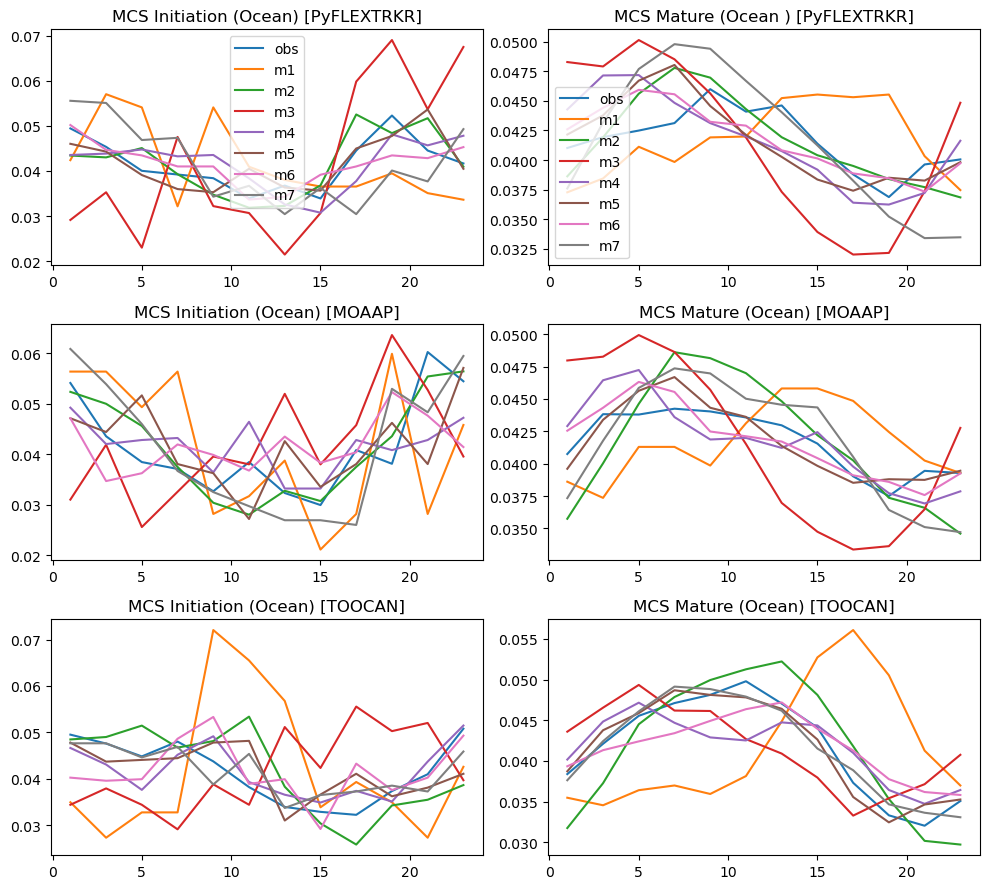

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(10,9), dpi=100)
# PyFLEXTRKR
ax00 = axes[0][0]
for key in name_map:
    ax00.plot(binhour_v, pdf_inithour_pyflex_o[key], label=f'{key}')
    ax00.legend()
ax01 = axes[0][1]
for key in name_map:
    ax01.plot(binhour_v, pdf_mcshour_pyflex_o[key], label=f'{key}')
    ax01.legend()
ax00.set_title('MCS Initiation (Ocean) [PyFLEXTRKR]')
ax01.set_title('MCS Mature (Ocean ) [PyFLEXTRKR]')
    
# MOAAP
ax10 = axes[1][0]
for key in name_map:
    ax10.plot(binhour_v, pdf_inithour_moaap_o[key], label=f'{key}')
ax11 = axes[1][1]
for key in name_map:
    ax11.plot(binhour_v, pdf_mcshour_moaap_o[key], label=f'{key}')
ax10.set_title('MCS Initiation (Ocean) [MOAAP]')
ax11.set_title('MCS Mature (Ocean) [MOAAP]')
    
# TOOCAN
ax20 = axes[2][0]
for key in name_map:
    ax20.plot(binhour_v, pdf_inithour_toocan_o[key], label=f'{key}')
ax21 = axes[2][1]
for key in name_map:
    ax21.plot(binhour_v, pdf_mcshour_toocan_o[key], label=f'{key}')
ax20.set_title('MCS Initiation (Ocean) [TOOCAN]')
ax21.set_title('MCS Mature (Ocean) [TOOCAN]')

fig.tight_layout()

## Calculate diurnal cycle amplitude and phase

In [42]:
nharm = 8   # Number of harmonics
binsize = 2  # diurnal hour bin size

amp_init_pyflex_l = {}
phs_init_pyflex_l = {}
amp_mat_pyflex_l = {}
phs_mat_pyflex_l = {}
amp_init_pyflex_o = {}
phs_init_pyflex_o = {}
amp_mat_pyflex_o = {}
phs_mat_pyflex_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_pyflex_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_pyflex_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_pyflex_l[key] = amp_init[0]
    phs_init_pyflex_l[key] = phs_init[0]
    amp_mat_pyflex_l[key] = amp_mat[0]
    phs_mat_pyflex_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_pyflex_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_pyflex_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_pyflex_o[key] = amp_init[0]
    phs_init_pyflex_o[key] = phs_init[0]
    amp_mat_pyflex_o[key] = amp_mat[0]
    phs_mat_pyflex_o[key] = phs_mat[0]

In [43]:
amp_init_moaap_l = {}
phs_init_moaap_l = {}
amp_mat_moaap_l = {}
phs_mat_moaap_l = {}
amp_init_moaap_o = {}
phs_init_moaap_o = {}
amp_mat_moaap_o = {}
phs_mat_moaap_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_moaap_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_moaap_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_moaap_l[key] = amp_init[0]
    phs_init_moaap_l[key] = phs_init[0]
    amp_mat_moaap_l[key] = amp_mat[0]
    phs_mat_moaap_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_moaap_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_moaap_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_moaap_o[key] = amp_init[0]
    phs_init_moaap_o[key] = phs_init[0]
    amp_mat_moaap_o[key] = amp_mat[0]
    phs_mat_moaap_o[key] = phs_mat[0]

In [44]:
amp_init_toocan_l = {}
phs_init_toocan_l = {}
amp_mat_toocan_l = {}
phs_mat_toocan_l = {}
amp_init_toocan_o = {}
phs_init_toocan_o = {}
amp_mat_toocan_o = {}
phs_mat_toocan_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_toocan_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_toocan_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_toocan_l[key] = amp_init[0]
    phs_init_toocan_l[key] = phs_init[0]
    amp_mat_toocan_l[key] = amp_mat[0]
    phs_mat_toocan_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_toocan_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_toocan_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_toocan_o[key] = amp_init[0]
    phs_init_toocan_o[key] = phs_init[0]
    amp_mat_toocan_o[key] = amp_mat[0]
    phs_mat_toocan_o[key] = phs_mat[0]

In [45]:
phs_init_pyflex_l, phs_init_moaap_l, phs_init_toocan_l

({'obs': 13.451821980248862,
  'm1': 18.081174768703328,
  'm2': 15.011455373327248,
  'm3': 12.171852341919399,
  'm4': 14.021117599877117,
  'm5': 13.69665744497007,
  'm6': 12.90855060233228,
  'm7': 13.877491872022041},
 {'obs': 11.805554092446457,
  'm1': nan,
  'm2': 13.142626202182804,
  'm3': 8.66349155808075,
  'm4': 12.991793120321741,
  'm5': 11.525795200645945,
  'm6': 10.309028481291136,
  'm7': 13.026655316567666},
 {'obs': 14.83069960042748,
  'm1': 18.336082697431266,
  'm2': 15.433312708847827,
  'm3': 11.534676113193242,
  'm4': 15.299033485572245,
  'm5': 15.20211870093933,
  'm6': 13.842679267588347,
  'm7': 15.293042583241208})

## Function to plot diurnal cycle for multiple trackers

In [46]:
def plot_diurnal_mxn(nrow, ncol, data_arr, amp_arr, phs_arr, binhour_v, 
                     titles=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None,
                     fontsize=None, legend_fontsize=None, ylims=None, amp_scale=None,
                     map_extent=None, lonbox=None, latbox=None, inset_param=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.20, hspace=0.3)
    
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }
    lw = 1.5
    lws = {
        'obs': lw*4, 
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
    }
    

    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            for key, val in data_arr[row][col].items():
                ax.plot(binhour_v, data_arr[row][col][key], lcolors[key], lw=lws[key], label=legends[row][col][key])
                yspan = (ylims[col][1] - ylims[col][0])
                amp = amp_arr[row][col][key] * amp_scale[col]  # scale the diurnal amplitude
                # Plot diurnal phase and amplitude
                ax.scatter(phs_arr[row][col][key], ylims[col][0]+yspan*0.01, s=15, marker='^', facecolor=lcolors[key])
                ax.axvline(phs_arr[row][col][key], ymax=ylims[col][0]+amp, color=lcolors[key], lw=lws[key])
            ax.grid(which='major', ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_xticks(xticks)
            ax.set_ylim(ylims[col][0], ylims[col][1])
            ax.set_title(titles[row][col], loc='left')
            ax.legend(fontsize=legend_fontsize, loc=legend_loc[row][col], ncol=legend_ncol[row][col])

            # # Plot inset map
            # if (inset_flag[row][col] == True):
            #     resolution = '110m'
            #     land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
            #     ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
            #     proj = ccrs.PlateCarree(central_longitude=180)
            #     box_proj = ccrs.PlateCarree(central_longitude=0)
            #     sub_ax = inset_axes(ax, width=inset_param[row][col]['width'], height=inset_param[row][col]['height'], loc=inset_param[row][col]['loc'],
            #                         axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param[row][col]['borderpad'], 
            #                         axes_kwargs=dict(projection=proj))
            #     sub_ax.set_extent(map_extent, box_proj)
            #     # Add land, coastlines, borders to inset
            #     sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
            #     sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
            #     sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
            #     # Plot a box region in the inset
            #     box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
            #     sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
            #     sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

In [47]:
init_legend_pyflex_l = {}
init_legend_moaap_l = {}
init_legend_toocan_l = {}
mat_legend_pyflex_l = {}
mat_legend_moaap_l = {}
mat_legend_toocan_l = {}

init_legend_pyflex_o = {}
init_legend_moaap_o = {}
init_legend_toocan_o = {}
mat_legend_pyflex_o = {}
mat_legend_moaap_o = {}
mat_legend_toocan_o = {}

for key in name_map:
    # Initiation
    init_legend_pyflex_l[key] = f"{name_map[key]} ({amp_init_pyflex_l[key]:.03f}, {phs_init_pyflex_l[key]:2.1f} h)"
    init_legend_moaap_l[key] = f"{name_map[key]} ({amp_init_moaap_l[key]:.03f}, {phs_init_moaap_l[key]:2.1f} h)"
    init_legend_toocan_l[key] = f"{name_map[key]} ({amp_init_toocan_l[key]:.03f}, {phs_init_toocan_l[key]:2.1f} h)"
    # Mature
    mat_legend_pyflex_l[key] = f"{name_map[key]} ({amp_mat_pyflex_l[key]:.03f}, {phs_mat_pyflex_l[key]:2.1f} h)"
    mat_legend_moaap_l[key] = f"{name_map[key]} ({amp_mat_moaap_l[key]:.03f}, {phs_mat_moaap_l[key]:2.1f} h)"
    mat_legend_toocan_l[key] = f"{name_map[key]} ({amp_mat_toocan_l[key]:.03f}, {phs_mat_toocan_l[key]:2.1f} h)"
    
    # Initiation
    init_legend_pyflex_o[key] = f"{name_map[key]} ({amp_init_pyflex_o[key]:.03f}, {phs_init_pyflex_o[key]:2.1f} h)"
    init_legend_moaap_o[key] = f"{name_map[key]} ({amp_init_moaap_o[key]:.03f}, {phs_init_moaap_o[key]:2.1f} h)"
    init_legend_toocan_o[key] = f"{name_map[key]} ({amp_init_toocan_o[key]:.03f}, {phs_init_toocan_o[key]:2.1f} h)"
    # Mature
    mat_legend_pyflex_o[key] = f"{name_map[key]} ({amp_mat_pyflex_o[key]:.03f}, {phs_mat_pyflex_o[key]:2.1f} h)"
    mat_legend_moaap_o[key] = f"{name_map[key]} ({amp_mat_moaap_o[key]:.03f}, {phs_mat_moaap_o[key]:2.1f} h)"
    mat_legend_toocan_o[key] = f"{name_map[key]} ({amp_mat_toocan_o[key]:.03f}, {phs_mat_toocan_o[key]:2.1f} h)"

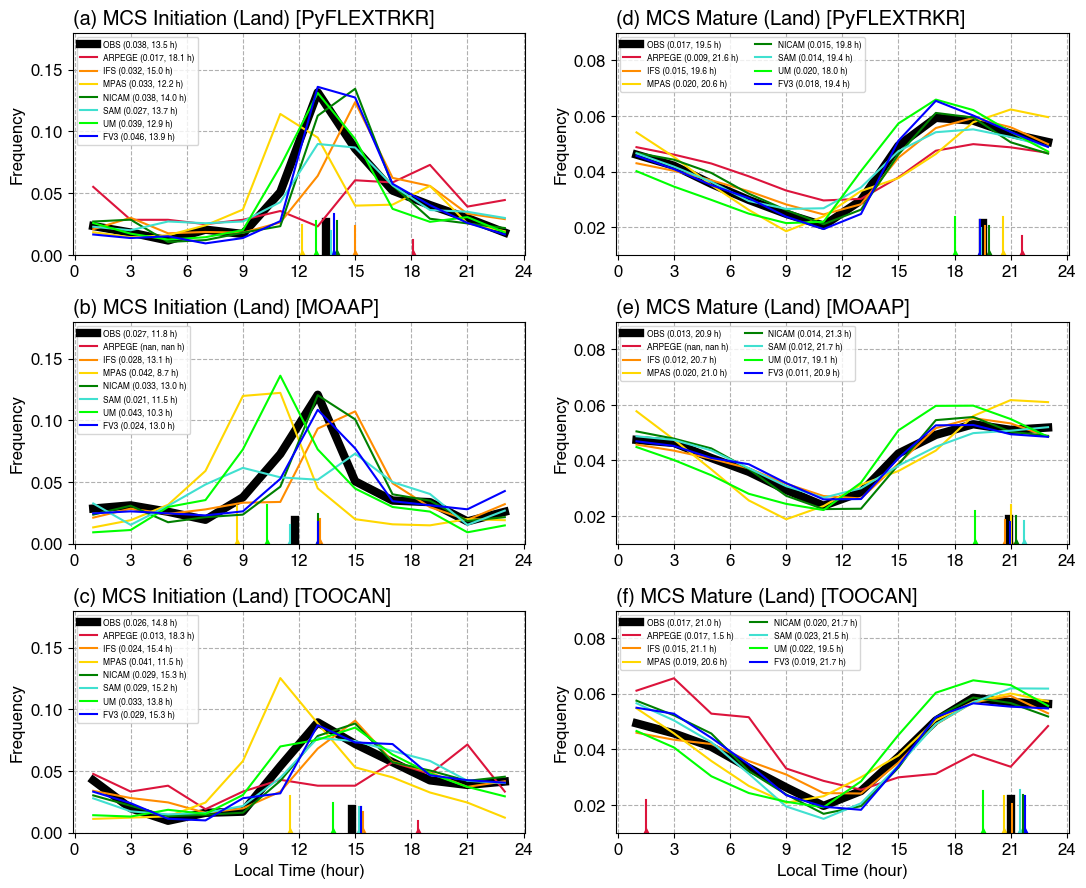

In [48]:
# Data array [row][col]
data_arr = [
    [pdf_inithour_pyflex_l, pdf_mcshour_pyflex_l],
    [pdf_inithour_moaap_l, pdf_mcshour_moaap_l],
    [pdf_inithour_toocan_l, pdf_mcshour_toocan_l],
]
amp_arr = [
    [amp_init_pyflex_l, amp_mat_pyflex_l],
    [amp_init_moaap_l, amp_mat_moaap_l],
    [amp_init_toocan_l, amp_mat_toocan_l],
]
phs_arr = [
    [phs_init_pyflex_l, phs_mat_pyflex_l],
    [phs_init_moaap_l, phs_mat_moaap_l],
    [phs_init_toocan_l, phs_mat_toocan_l],
]
legends = [
    [init_legend_pyflex_l, mat_legend_pyflex_l],
    [init_legend_moaap_l, mat_legend_moaap_l],
    [init_legend_toocan_l, mat_legend_toocan_l],
]
titles = [
    ['(a) MCS Initiation (Land) [PyFLEXTRKR]', '(d) MCS Mature (Land) [PyFLEXTRKR]'],
    ['(b) MCS Initiation (Land) [MOAAP]', '(e) MCS Mature (Land) [MOAAP]'],
    ['(c) MCS Initiation (Land) [TOOCAN]', '(f) MCS Mature (Land) [TOOCAN]']
]
# xlabels = [['Local Time (hour)','Local Time (hour)'],['Local Time (hour)','Local Time (hour)'],['Local Time (hour)','Local Time (hour)']]
xlabels = [['',''],['',''],['Local Time (hour)','Local Time (hour)']]
ylabels = [['Frequency', 'Frequency'],['Frequency', 'Frequency'],['Frequency', 'Frequency']]
xticks = np.arange(0,25,3)
ylims = [(0.0,0.18),(0.01,0.09)]
amp_scale = [4, 8]

legend_loc = [['upper left','upper left'],['upper left','upper left'],['upper left','upper left']]
legend_ncol = [[1,2],[1,2],[1,2]]
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
if (bounds[0] > 180) & (bounds[1] > 180):
    lonbox = ((np.array([bounds[0], bounds[1]]) - 180) % 360) - 180
else:
    lonbox = np.array([bounds[0], bounds[1]])
latbox = [bounds[2], bounds[3]]
inset_param = [
    [{'width':'35%', 'height':'20%', 'loc':'lower right', 'borderpad':0.2}, 
     {'width':'35%', 'height':'20%', 'loc':'upper right', 'borderpad':0.2}],
    [{'width':'35%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}, 
     {'width':'35%', 'height':'20%', 'loc':'upper left', 'borderpad':0.2}],
]
inset_flag = [[False, False], [False, False]]
fontsize = 12
legend_fontsize = 6
figsize = [12,10]
figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_land_all.png'
fig = plot_diurnal_mxn(3, 2, data_arr, amp_arr, phs_arr, binhour_v, 
                       titles=titles, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                       fontsize=fontsize, legend_fontsize=legend_fontsize, ylims=ylims, amp_scale=amp_scale,
                       map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, figname=figname, figsize=figsize, inset_flag=inset_flag)

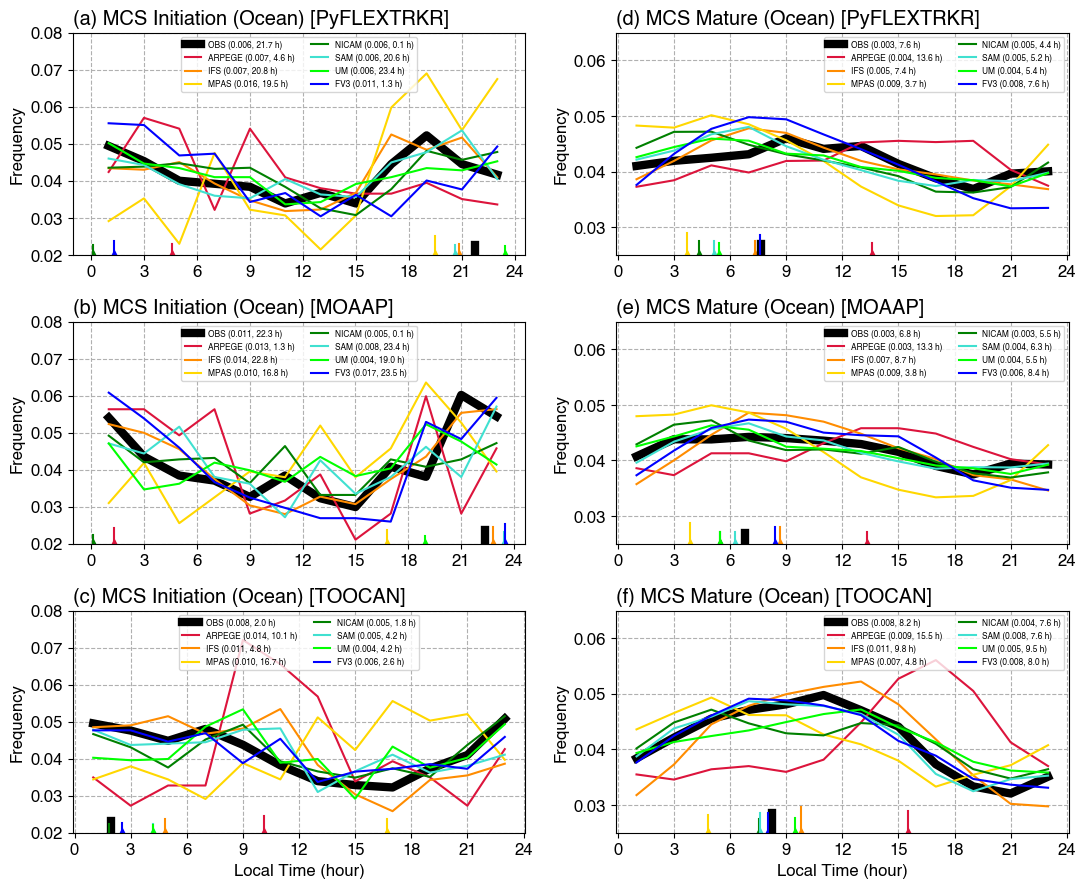

In [49]:
# Data array [row][col]
data_arr = [
    [pdf_inithour_pyflex_o, pdf_mcshour_pyflex_o],
    [pdf_inithour_moaap_o, pdf_mcshour_moaap_o],
    [pdf_inithour_toocan_o, pdf_mcshour_toocan_o],
]
amp_arr = [
    [amp_init_pyflex_o, amp_mat_pyflex_o],
    [amp_init_moaap_o, amp_mat_moaap_o],
    [amp_init_toocan_o, amp_mat_toocan_o],
]
phs_arr = [
    [phs_init_pyflex_o, phs_mat_pyflex_o],
    [phs_init_moaap_o, phs_mat_moaap_o],
    [phs_init_toocan_o, phs_mat_toocan_o],
]
legends = [
    [init_legend_pyflex_o, mat_legend_pyflex_o],
    [init_legend_moaap_o, mat_legend_moaap_o],
    [init_legend_toocan_o, mat_legend_toocan_o],
]
titles = [
    ['(a) MCS Initiation (Ocean) [PyFLEXTRKR]', '(d) MCS Mature (Ocean) [PyFLEXTRKR]'],
    ['(b) MCS Initiation (Ocean) [MOAAP]', '(e) MCS Mature (Ocean) [MOAAP]'],
    ['(c) MCS Initiation (Ocean) [TOOCAN]', '(f) MCS Mature (Ocean) [TOOCAN]']
]
xlabels = [['',''],['',''],['Local Time (hour)','Local Time (hour)']]
ylabels = [['Frequency', 'Frequency'],['Frequency', 'Frequency'],['Frequency', 'Frequency']]
xticks = np.arange(0,25,3)
ylims = [(0.02,0.08),(0.025,0.065)]
amp_scale = [4, 8]

legend_loc = [['upper center','upper right'],['upper center','upper right'],['upper center','upper right']]
legend_ncol = [[2,2],[2,2],[2,2]]

inset_flag = [[False, False], [False, False]]
fontsize = 12
legend_fontsize = 6
figsize = [12,10]
figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_ocean_all.png'
fig = plot_diurnal_mxn(3, 2, data_arr, amp_arr, phs_arr, binhour_v, 
                       titles=titles, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                       fontsize=fontsize, legend_fontsize=legend_fontsize, ylims=ylims, amp_scale=amp_scale,
                       map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, figname=figname, figsize=figsize, inset_flag=inset_flag)

In [50]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/mcs_initiation_mature_time_diurnal_cycle_ocean_all.png'